In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from pathlib import Path
import glob
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import copy
import pandas as pd
import numpy as np
import torch

from sklearn.metrics import roc_auc_score

os.environ["WANDB_SILENT"] = "true"

from owkin.training import train, RocLoss
from owkin.dataset import build_dataset
from owkin.models.mono_models import MLP, SVM
from owkin.models.aggregators import SmoothMaxAggregator, MaxAggregator

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

from scipy.stats import t

from statistics import variance, mean 

## TODO:

Look at the differences between the centers

train_val = [C_1, C_2, C5]

test = [C_3, C_4]

## Observation:

- a correction is needed for each center, especially C_4, but also C_3 and C_5 

In [9]:
data_path = "../data/"
"""
Build `X_train_mean, X_val_mean, X_train, X_val, y_train, y_val`
TODO: add other aggregation that mean (e.g. max) ? Use a dict ?
"""

# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path(data_path)

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train_val = pd.read_csv(data_dir / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir / "supplementary_data" / "test_metadata.csv")


# concatenate y_train_val and df_train_val
y_train_val = pd.read_csv(data_dir / "train_output.csv")
df_train_val = df_train_val.merge(y_train_val, on="Sample ID")


In [10]:
X_train_val_mean = []
X_train_val = []
y_train_val = []

centers_train_val = []
patients_train_val = []

for sample, label, center, patient in df_train_val[
    ["Sample ID", "Target", "Center ID", "Patient ID"]
].values:
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks

    # slide-level averaging
    X_train_val_mean.append(np.mean(features, axis=0))
    X_train_val.append(features)
    y_train_val.append(label)

    centers_train_val.append(center)
    patients_train_val.append(patient)

# convert to numpy arrays
X_train_val_mean = np.array(X_train_val_mean)
X_train_val = np.array(X_train_val)
y_train_val = np.array(y_train_val)

centers_train_val = np.array(centers_train_val)
patients_train_val = np.array(patients_train_val)

patients_unique = np.unique(patients_train_val)
y_unique = np.array(
    [np.mean(y_train_val[patients_train_val == p]) for p in patients_unique]
)


X_test = []
X_test_mean = []
centers_test = []
patients_test = []


# load the data from `df_test` (~ 1 minute)
for sample, center, patient in df_test[
    ["Sample ID", "Center ID", "Patient ID"]
].values:
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(features)
    X_test_mean.append(np.mean(features, axis=0))
    centers_test.append(center)
    patients_test.append(patient)

X_test = np.array(X_test)
X_test_mean = np.array(X_test_mean)

centers_test = np.array(centers_test)
patients_test = np.array(patients_test)

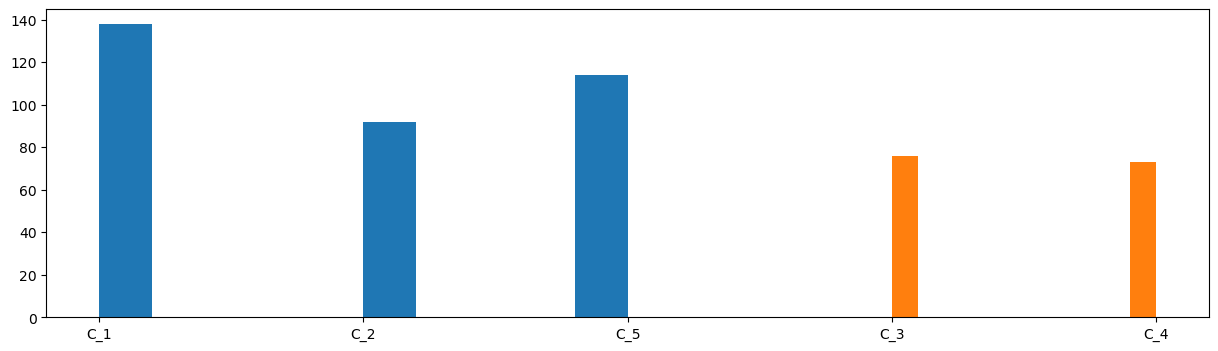

In [11]:
plt.figure(figsize=(15,4))
plt.hist(centers_train_val, label = "train")
plt.hist(centers_test, label = "test")
plt.show()

In [12]:
num_feature = X_train_val.shape[-1]

centers = ["C_1", "C_2", "C_5", "C_3", "C_4"]

colors = {
    #train_val
    "C_1": "lime",
    "C_2": "blue",
    "C_5": "cyan",
    #test
    "C_3": "magenta",
    "C_4": "red",
    #all
    "all": "grey"
}

In [7]:
y = dict()
for center in centers[:-2] :
    y[center] = y_train_val[centers_train_val == center]
    nb_pos = y[center].sum()
    nb_neg = (1-y[center]).sum()
    print(f"center {center}: {nb_pos} positive and {nb_neg} negative, for a proportion of {nb_pos/(nb_pos+nb_neg)}")

center C_1: 49 positive and 89 negative, for a proportion of 0.35507246376811596
center C_2: 33 positive and 59 negative, for a proportion of 0.358695652173913
center C_5: 46 positive and 68 negative, for a proportion of 0.40350877192982454


In [8]:
X_all = np.concatenate([X_train_val, X_test], axis=0)
centers_all = np.concatenate([centers_train_val, centers_test])

X_all_flat = X_all.reshape(-1, num_feature)

## Without any scale

In [9]:
X = dict()
X_flat = dict()

for center in centers:
    X[center] = X_all[centers_all == center]
    X_flat[center] = X[center].reshape(-1, num_feature)

X["all"] = X_all
X_flat["all"] = X_all.reshape(-1, num_feature)

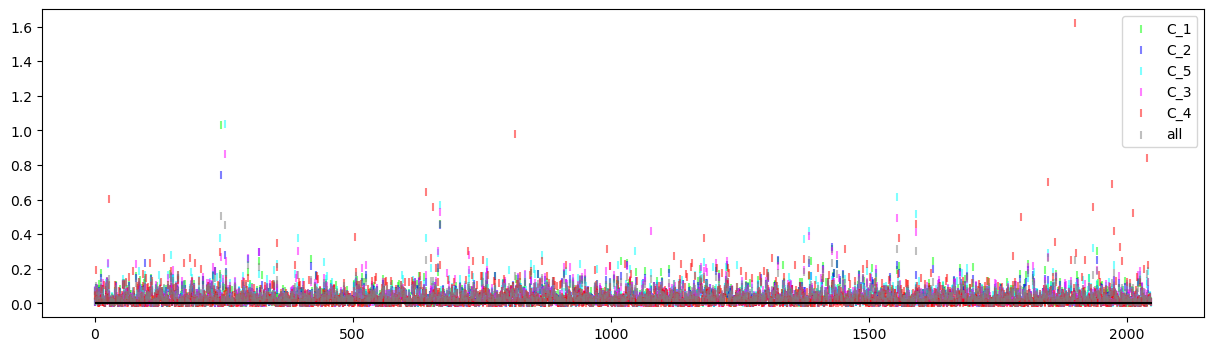

In [10]:
plt.figure(figsize=(15,4))

for center in X_flat.keys():
    plt.scatter(np.arange(num_feature), X_flat[center].mean(axis=0), label = center, alpha=0.5, marker="|", color=colors[center])

plt.hlines(0, 0, num_feature, color="black")

plt.legend()
plt.show()

### Max of each lime

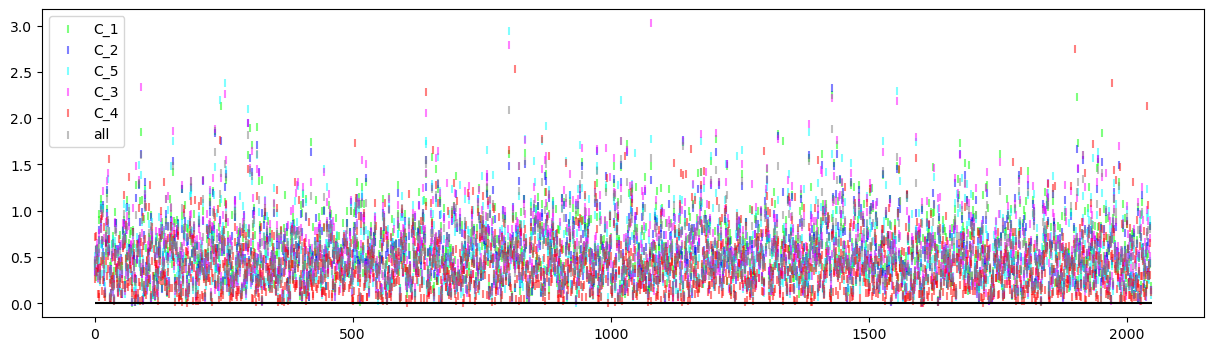

In [11]:
plt.figure(figsize=(15,4))

for center in X_flat.keys():
    plt.scatter(np.arange(num_feature), X[center].max(axis=1).mean(axis=0), label = center, alpha=0.5, marker="|", color=colors[center])

plt.hlines(0, 0, num_feature, color="black")

plt.legend()
plt.show()

## Scale fit only on train_val

In [12]:
X_train_val_flat = X_train_val.reshape([-1, num_feature])

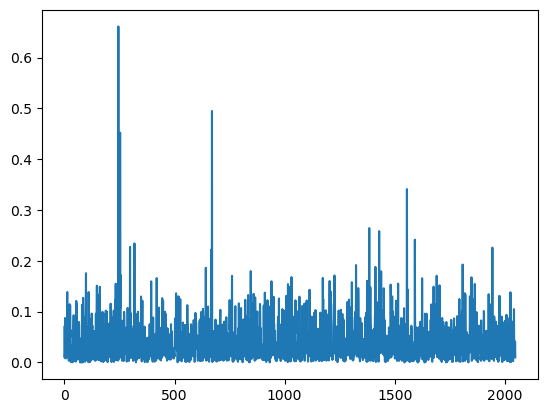

In [13]:
scaler = StandardScaler()
scaler.fit(X_train_val_flat)

plt.plot(scaler.mean_)

In [14]:
X_norm =  np.zeros_like(X_all)
for i, lime in enumerate(X_all):
    X_norm[i] = scaler.transform(lime)

In [15]:
X = dict()
X_flat = dict()

for center in centers:
    X[center] = X_norm[centers_all == center]
    X_flat[center] = X[center].reshape(-1, num_feature)

X["all"] = X_norm
X_flat["all"] = X_norm.reshape(-1, num_feature)

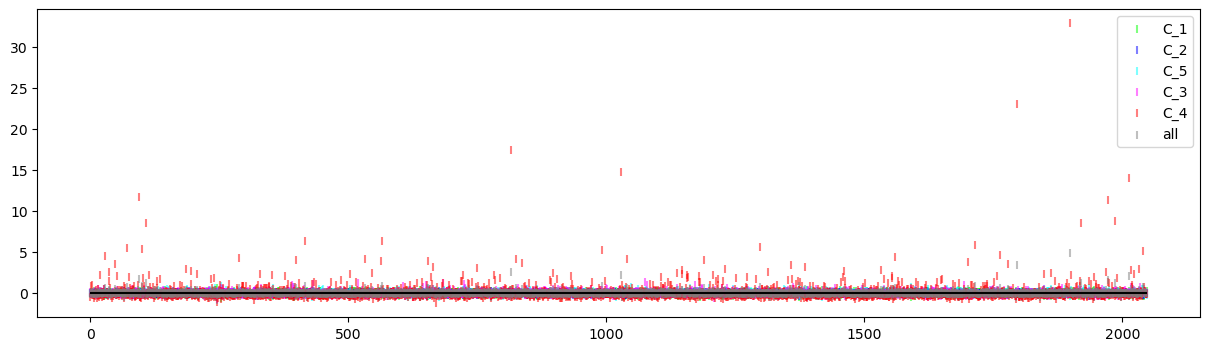

In [16]:
plt.figure(figsize=(15,4))

for center in X_flat.keys():
    plt.scatter(np.arange(num_feature), X_flat[center].mean(axis=0), label = center, alpha=0.5, marker="|", color=colors[center])

plt.hlines(0, 0, num_feature, color="black")

plt.legend()
plt.show()

### Max of each lime

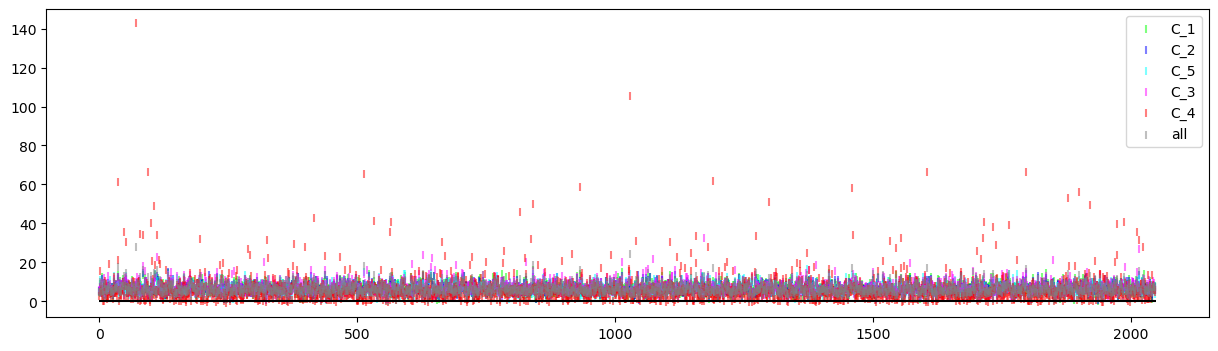

In [17]:
plt.figure(figsize=(15,4))

for center in X_flat.keys():
    plt.scatter(np.arange(num_feature), X[center].max(axis=1).mean(axis=0), label = center, alpha=0.5, marker="|", color=colors[center])

plt.hlines(0, 0, num_feature, color="black")

plt.legend()
plt.show()

## Scaler fit on all centers

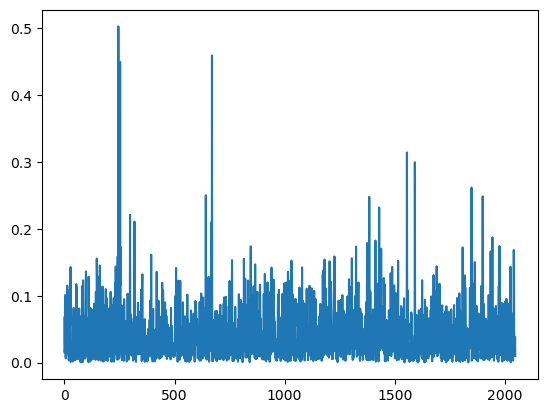

In [18]:
scaler = StandardScaler()
scaler.fit(X_all_flat)

plt.plot(scaler.mean_)

In [19]:
X_norm =  np.zeros_like(X_all)
for i, lime in enumerate(X_all):
    X_norm[i] = scaler.transform(lime)

In [20]:
X = dict()
X_flat = dict()

for center in centers:
    X[center] = X_norm[centers_all == center]
    X_flat[center] = X[center].reshape(-1, num_feature)

X["all"] = X_norm
X_flat["all"] = X_norm.reshape(-1, num_feature)

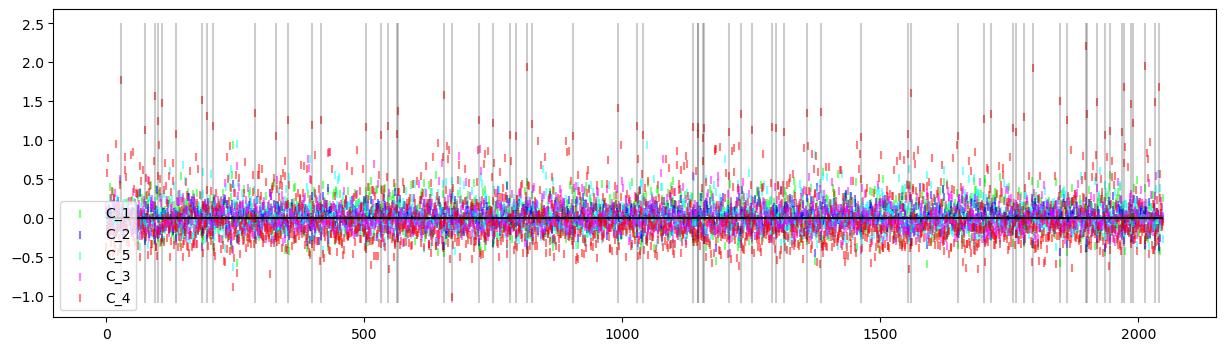

In [21]:
plt.figure(figsize=(15,4))

trace_vlines = dict()

for center in centers:
    plt.scatter(np.arange(num_feature), X_flat[center].mean(axis=0), label = center, alpha=0.5, marker="|", color=colors[center])
    trace_vlines[center] = np.abs(X_flat[center].mean(axis=0))>1

mask = np.array(list(trace_vlines.values())).sum(axis=0) > 0

plt.hlines(0, 0, num_feature, color="black")

plt.vlines(np.arange(num_feature)[mask], -1.1, 2.5, alpha=0.2, color="black")

plt.legend(loc="lower left")
plt.show()

### Max of each lime

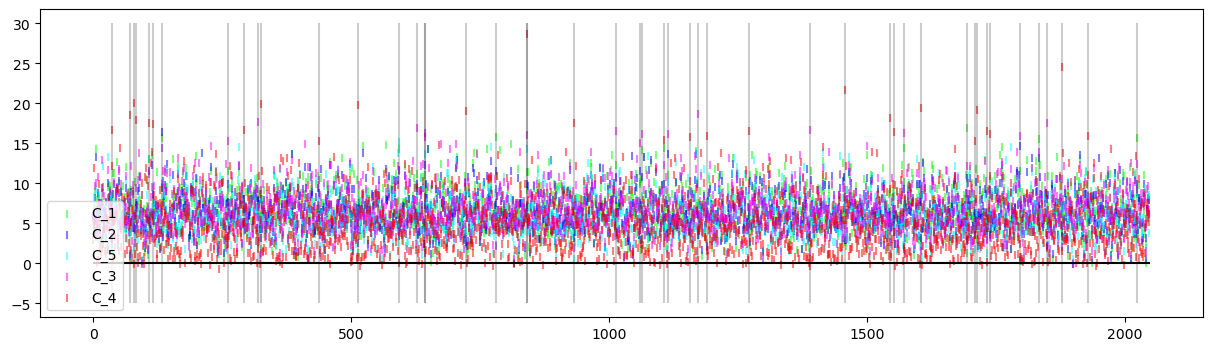

In [22]:
plt.figure(figsize=(15,4))

trace_vlines = dict()

for center in centers:
    plt.scatter(np.arange(num_feature), X[center].max(axis=1).mean(axis=0), label = center, alpha=0.5, marker="|", color=colors[center])
    trace_vlines[center] = np.abs(X[center].max(axis=1).mean(axis=0))>15

mask = np.array(list(trace_vlines.values())).sum(axis=0) > 0

plt.hlines(0, 0, num_feature, color="black")
plt.vlines(np.arange(num_feature)[mask], -5, 30, alpha=0.2, color="black")

plt.legend(loc="lower left")
plt.show()